# plot_hysteresis.ipynb

Author: Robert M. Frost

University of Oklahoma

Created: 12 September 2023

Purpose: Plot roll factor $\mathcal{R}$ and length scale ratios $\lambda_{x'}^{w} / \lambda_{y'}^{w}$ vs $-z_i / L$

In [1]:
import sys
sys.path.append("/home/rfrost/LES-utils/")

import seaborn
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
from LESutils import load_full
import seaborn

In [2]:
# location of netCDF simulation output
output = "/home/rfrost/simulations/nc/"
# name of simulation
sims = ["full_step_6", "full_step_9", "full_step_12", "full_step_15"]
# directory to save figures
figdir = "/home/rfrost/manuscript_plots/"

# timesteps
t0 = 576000
t1 = 1152000
# start/end times in hours
t0hr = t0 * 0.05 / 3600
t1hr = t1 * 0.05 / 3600

# height indice (0=0.10, 1=0.25, 2=0.50)
hidx = 1

# timesteps to average over
avg = 24

In [3]:
# plotting setup

# Set the font weight for plot titles
plt.rcParams['axes.titleweight'] = 'bold'

# Set the font weight for x-axis and y-axis labels
plt.rcParams['axes.labelweight'] = 'normal'

plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

# Other plotting setup
rc('font', family='sans-serif')
# plt.rcParams['font.family'] = 'DejaVu Sans'
rc('font', weight='normal', size=17.5)
rc('figure', facecolor='white') 

In [4]:
# Get the current default sans-serif font
# default_font = plt.rcParams['font.sans-serif']
# print(f"Default sans-serif font: {default_font}")

In [5]:
# read in roll factor
r6 = xr.open_dataarray(f"{output}full_step_6/rollfactor.nc")
r6 = r6.rolling(time=avg).mean()
r9 = xr.open_dataarray(f"{output}full_step_9/rollfactor.nc")
r9 = r9.rolling(time=avg).mean()
r12 = xr.open_dataarray(f"{output}full_step_12/rollfactor.nc")
r12 = r12.rolling(time=avg).mean()
r15 = xr.open_dataarray(f"{output}full_step_15/rollfactor.nc")
r15 = r15.rolling(time=avg).mean()
# xarray dataset to store
roll = xr.Dataset(
    data_vars=dict(
        ug6=(["height", "time"], r6.values),
        ug9=(["height", "time"], r9.values),
        ug12=(["height", "time"], r12.values),
        ug15=(["height", "time"], r15.values)
    ),
    coords=dict(
        heights=r6.heights.values,
        time=r6.time.values)
)
# convert time to hours
roll["time"] = roll.time / 3600 + t0hr

# read in length scales
ls6 = xr.open_dataset(f"{output}full_step_6/{t0}_{t1}_length_scale_rot.nc")
ls6 = (ls6.rolls / ls6.normal).rolling(time=avg).mean()
ls9 = xr.open_dataset(f"{output}full_step_9/{t0}_{t1}_length_scale_rot.nc")
ls9 = (ls9.rolls / ls9.normal).rolling(time=avg).mean()
ls12 = xr.open_dataset(f"{output}full_step_12/{t0}_{t1}_length_scale_rot.nc")
ls12 = (ls12.rolls / ls12.normal).rolling(time=avg).mean()
ls15 = xr.open_dataset(f"{output}full_step_15/{t0}_{t1}_length_scale_rot.nc")
ls15 = (ls15.rolls / ls15.normal).rolling(time=avg).mean()
# convert time to hours
ls6["time"] = ls6.time / 3600 + t0hr

# read in stats
s_all = []
for sim in sims:
    dnc = f"{output}{sim}/"
    s = xr.open_dataset(f"{dnc}{t0}_{t1}_stats.nc")
    s["time"] = s.time / 3600 + t0hr
    s["zi_L"] = s.zi_L.rolling(time=avg).mean()
    s_all.append(s)

In [6]:
heights = roll.heights
ntime = s.time.size

In [7]:
# array to hold indicies of z/zi
jz = np.zeros((len(sims),ntime))

for i, s in enumerate(s_all):
    for jt in range(ntime):
        jz[i,jt] = abs(s_all[i].z/s_all[i].zi[jt] - heights[hidx]).argmin()

jz = jz.astype(int)

In [8]:
ts6, ts9, ts12, ts15 = [np.zeros(ntime) for _ in range(4)]
for jt in range(ntime):
    ts6[jt] = ls6.isel(z=jz[0,jt], time=jt)
    ts9[jt] = ls9.isel(z=jz[1,jt], time=jt)
    ts12[jt] = ls12.isel(z=jz[2,jt], time=jt)
    ts15[jt] = ls15.isel(z=jz[3,jt], time=jt)

In [9]:
# xarray dataset to store ls
ls = xr.Dataset(
    data_vars=dict(
        ug6=(["time"], ts6),
        ug9=(["time"], ts9),
        ug12=(["time"], ts12),
        ug15=(["time"], ts15),
    ),
    coords=dict(
        time=ls6.time.values
        )
)

## $\mathcal{R}$ and $\lambda_{w}^{x'} / \lambda_{w}^{y'}$

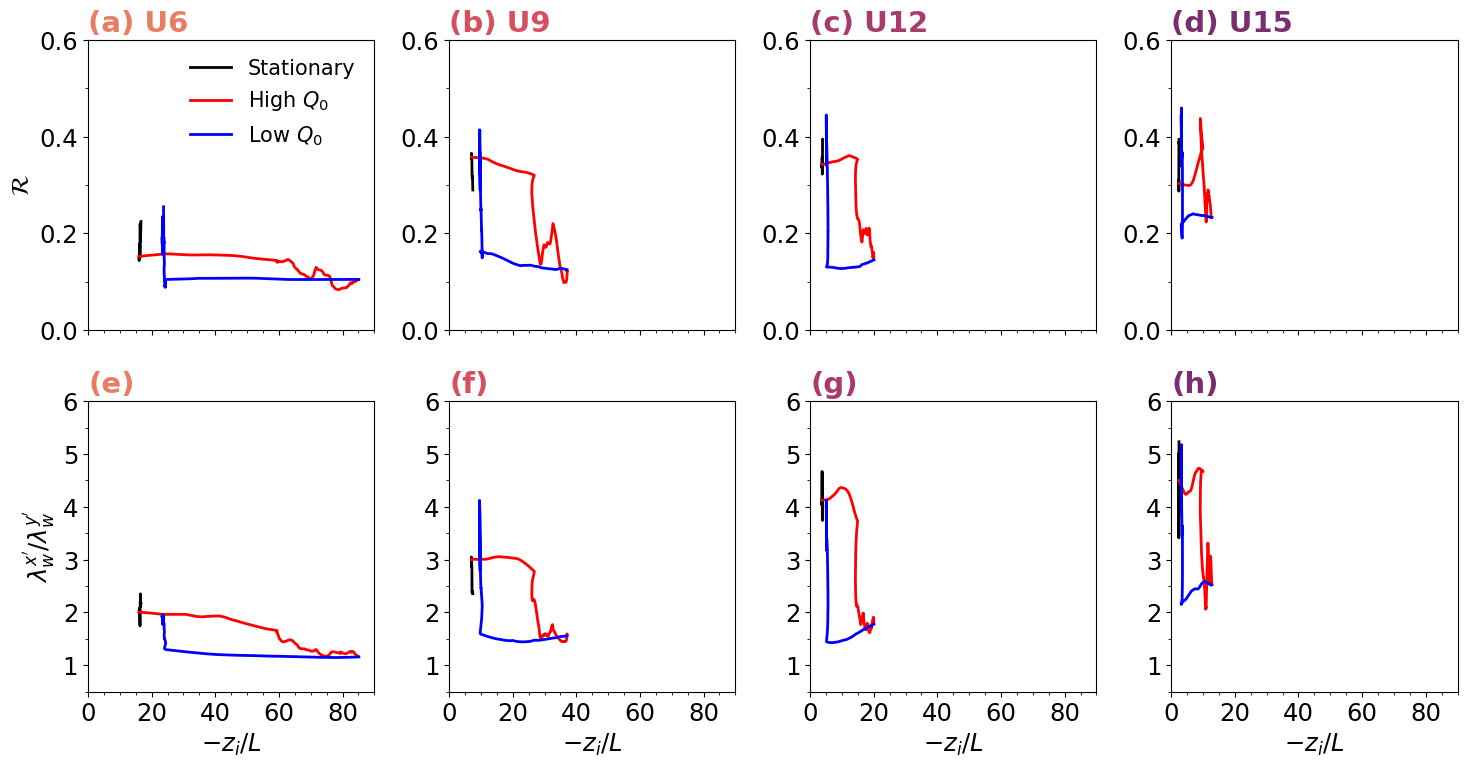

In [10]:
colors2 = ["black", "red", "blue"]
ug_colors = seaborn.color_palette("flare", 4)

fig, ax = plt.subplots(figsize=(15,8), nrows=2, ncols=4, sharex=True)

# 6 m/s
# ls ratio
ax[1,0].plot(s_all[0].zi_L[:144], ls.ug6[:144], 
             label="Stationary", c=colors2[0], lw=2)
ax[1,0].plot(s_all[0].zi_L[144:360], ls.ug6[144:360], 
             label="High $Q_0$", c=colors2[1], lw=2)
ax[1,0].plot(s_all[0].zi_L[360:], ls.ug6[360:], 
             label="Step Down", c=colors2[2], lw=2)
# roll factor
ax[0,0].plot(s_all[0].zi_L[:144], roll.ug6[hidx,:144], 
             label="Stationary", c=colors2[0], lw=2)
ax[0,0].plot(s_all[0].zi_L[144:360], roll.ug6[hidx,144:360], 
             label="High $Q_0$", c=colors2[1], lw=2)
ax[0,0].plot(s_all[0].zi_L[360:], roll.ug6[hidx,360:], 
             label="Low $Q_0$", c=colors2[2], lw=2)

# 9 m/s
# ls ratio
ax[1,1].plot(s_all[1].zi_L[:144], ls.ug9[:144], 
             label="Stationary", c=colors2[0], lw=2)
ax[1,1].plot(s_all[1].zi_L[144:360], ls.ug9[144:360], 
             label="High $Q_0$", c=colors2[1], lw=2)
ax[1,1].plot(s_all[1].zi_L[360:], ls.ug9[360:], 
             label="Step Down", c=colors2[2], lw=2)
# roll factor
ax[0,1].plot(s_all[1].zi_L[:144], roll.ug9[hidx,:144], 
             label="Stationary", c=colors2[0], lw=2)
ax[0,1].plot(s_all[1].zi_L[144:360], roll.ug9[hidx,144:360], 
             label="Ramp Up", c=colors2[1], lw=2)
ax[0,1].plot(s_all[1].zi_L[360:], roll.ug9[hidx,360:], 
             label="Back Down", c=colors2[2], lw=2)

# 12 m/s
# ls ratio
ax[1,2].plot(s_all[2].zi_L[:144], ls.ug12[:144], 
             label="Stationary", c=colors2[0], lw=2)
ax[1,2].plot(s_all[2].zi_L[144:360], ls.ug12[144:360], 
             label="Step Up", c=colors2[1], lw=2)
ax[1,2].plot(s_all[2].zi_L[360:], ls.ug12[360:], 
             label="Step Down", c=colors2[2], lw=2)
# roll factor
ax[0,2].plot(s_all[2].zi_L[:144], roll.ug12[hidx,:144], 
             label="Stationary", c=colors2[0], lw=2)
ax[0,2].plot(s_all[2].zi_L[144:360], roll.ug12[hidx,144:360], 
             label="Ramp Up", c=colors2[1], lw=2)
ax[0,2].plot(s_all[2].zi_L[360:], roll.ug12[hidx,360:], 
             label="Back Down", c=colors2[2], lw=2)

# 15 m/s
# ls ratio
ax[1,3].plot(s_all[3].zi_L[:144], ls.ug15[:144], 
             label="Stationary", c=colors2[0], lw=2)
ax[1,3].plot(s_all[3].zi_L[144:360], ls.ug15[144:360], 
             label="Step Up", c=colors2[1], lw=2)
ax[1,3].plot(s_all[3].zi_L[360:], ls.ug15[360:], 
             label="Step Down", c=colors2[2], lw=2)
# roll factor
ax[0,3].plot(s_all[3].zi_L[:144], roll.ug15[hidx,:144], 
             label="Stationary", c=colors2[0], lw=2)
ax[0,3].plot(s_all[3].zi_L[144:360], roll.ug15[hidx,144:360], 
             label="Ramp Up", c=colors2[1], lw=2)
ax[0,3].plot(s_all[3].zi_L[360:], roll.ug15[hidx,360:], 
             label="Back Down", c=colors2[2], lw=2)

# axis limits
for i, iax in enumerate(ax[1,:]):
    iax.set_ylim(0.5,6)
    iax.yaxis.set_major_locator(MultipleLocator(1))
    iax.yaxis.set_minor_locator(MultipleLocator(0.5))
    iax.set_xlabel("$-z_i / L$")
for i, iax in enumerate(ax[0,:]):
    iax.set_xlim(0,90)
    iax.set_ylim(0,0.6)
    iax.yaxis.set_major_locator(MultipleLocator(0.2))
    iax.yaxis.set_minor_locator(MultipleLocator(0.1))
    iax.xaxis.set_minor_locator(MultipleLocator(5))
    iax.xaxis.set_major_locator(MultipleLocator(20))

# axis limits
ax[1,0].set_ylabel("$\lambda_{w}^{x'} / \lambda_{w}^{y'}$")
ax[0,0].set_ylabel("$\mathcal{R}$")

# legend
ax[0,0].legend(frameon=False, fontsize=15, loc="upper right")

# titles
ax[0,0].set_title(f"(a) U6", loc="left", c=ug_colors[0])
ax[0,1].set_title(f"(b) U9", loc="left", c=ug_colors[1])
ax[0,2].set_title(f"(c) U12", loc="left", c=ug_colors[2])
ax[0,3].set_title(f"(d) U15", loc="left", c=ug_colors[3])
ax[1,0].set_title("(e)", loc="left", c=ug_colors[0])
ax[1,1].set_title("(f)", loc="left", c=ug_colors[1])
ax[1,2].set_title("(g)", loc="left", c=ug_colors[2])
ax[1,3].set_title("(h)", loc="left", c=ug_colors[3])

fig.tight_layout()
plt.savefig(f"{figdir}fig10.pdf", format="pdf", dpi=300, bbox_inches="tight")

# Time series

In [11]:
# find average T_L at hr 9.8333
T_L = (906.23 + 923.55 + 937.68 + 960.66) / 4

tb = -2
tc = 4.5
td = 11
te = 17.5
tf = 24

tlmax = max(((ls.time-10)*3600)/T_L)
tlmin = min(((ls.time-10))*3600/T_L)

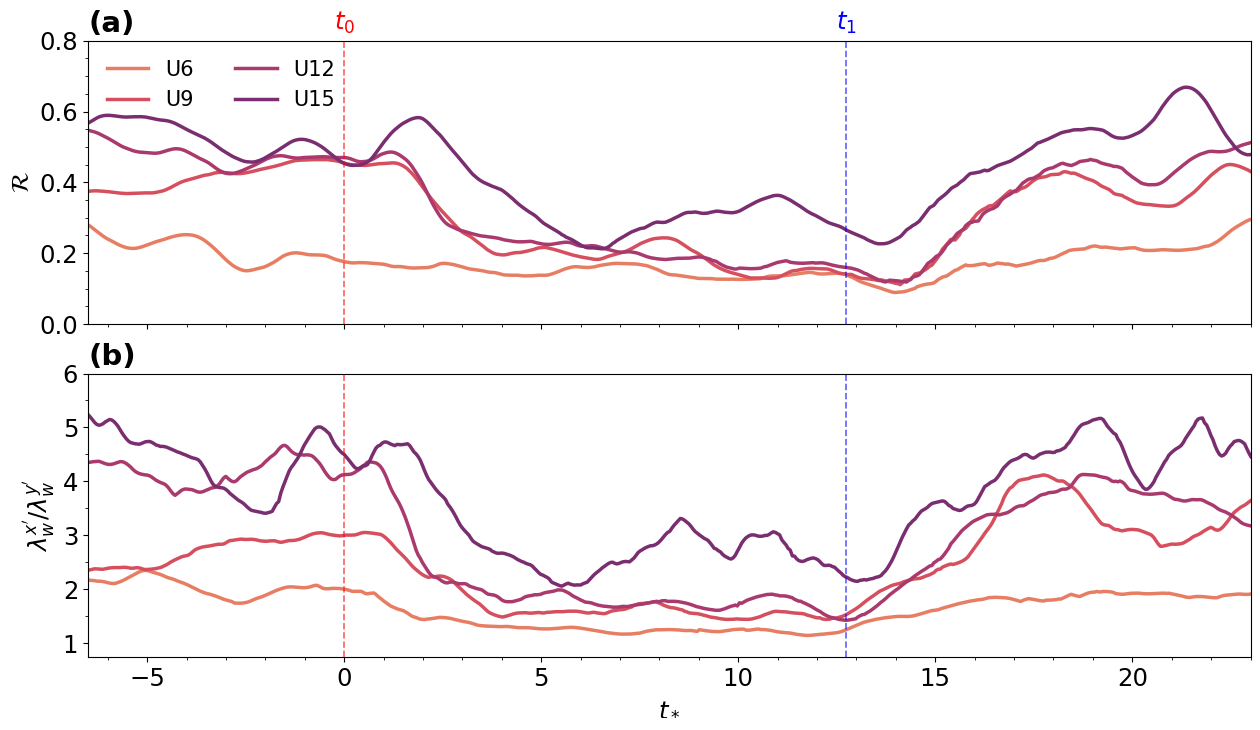

In [16]:
labels = [1, 2, 3, 4]
uglist = ["6", "9", "12", "15"]

fig, ax = plt.subplots(nrows=2, figsize=(15,8), sharex=True)

for i, s in enumerate(s_all):
    ax[0].plot(((roll.time-10)*3600) / T_L, roll[f"ug{uglist[i]}"][hidx],
               c=ug_colors[i], label=f"U{uglist[i]}", lw=2.5)
    ax[1].plot(((ls.time-10)*3600) / T_L,  ls[f"ug{uglist[i]}"],
               c=ug_colors[i], lw=2.5)

# legend
legend_location = (0.3, 0.7)
ax[0].legend(frameon=False, ncols=2, loc="upper left", fontsize=15)

# axis lims
ax[1].set_ylim(0.75,6)
ax[1].yaxis.set_major_locator(MultipleLocator(1))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.5))
ax[0].set_xlim(-6.5, 23)
ax[0].xaxis.set_major_locator(MultipleLocator(5))
ax[0].xaxis.set_minor_locator(MultipleLocator(1))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[0].set_ylim(0,0.8)

# axis labels
ax[1].set_ylabel("$\lambda_{w}^{x'} / \lambda_{w}^{y'}$")
ax[0].set_ylabel("$\mathcal{R}$")
ax[1].set_xlabel("$t_*$")

# spacing
fig.subplots_adjust(hspace=0.175)

# lines
ax[0].axvline(x=0, c="red", lw=1.25, alpha=0.6, ls="--")
ax[0].axvline(x=12.73795202, c="blue", lw=1.25, alpha=0.6, ls="--")
ax[1].axvline(x=0, c="red", lw=1.25, alpha=0.6, ls="--")
ax[1].axvline(x=12.73795202, c="blue", lw=1.25, alpha=0.6, ls="--")
ax[0].text(0, 0.85, "$t_0$", ha="center", va="center", c="red")
ax[0].text(12.73795202, 0.85, "$t_1$", ha="center", va="center", c="blue")

# titles
ax[0].set_title("(a)", loc="left")
ax[1].set_title("(b)", loc="left")

plt.savefig("/home/rfrost/manuscript_plots/fig9.pdf", format="pdf", dpi=300, bbox_inches="tight")

### Compare to Salesky et al. (2017)

In [13]:
# Read the data from the file
dtxt = ["/home/rfrost/2017_R_vs_ziL/roll_factor_les_zzi025_160.txt",
        "/home/rfrost/2017_R_vs_ziL/roll_factor_les_zzi025_256.txt",
        "/home/rfrost/2017_R_vs_ziL/roll_factor_les_zzi050_160.txt",
        "/home/rfrost/2017_R_vs_ziL/roll_factor_les_zzi050_256.txt"]

# 160^3, z/zi = 0.25
data = np.genfromtxt(dtxt[0], delimiter='\t', skip_header=1, invalid_raise=False, dtype=float)
# Extract -zi/L and R columns
salesky_160_zzi025_ziL = data[:, 0]
salesky_160_zzi025_R = data[:, 1]

# 256^3, z/zi = 0.25
data = np.genfromtxt(dtxt[1], delimiter='\t', skip_header=1, invalid_raise=False, dtype=float)
# Extract -zi/L and R columns
salesky_256_zzi025_ziL = data[:, 0]
salesky_256_zzi025_R = data[:, 1]

# 160^3, z/zi = 0.25
data = np.genfromtxt(dtxt[2], delimiter='\t', skip_header=1, invalid_raise=False, dtype=float)
# Extract -zi/L and R columns
salesky_160_zzi050_ziL = data[:, 0]
salesky_160_zzi050_R = data[:, 1]

# 256^3, z/zi = 0.25
data = np.genfromtxt(dtxt[3], delimiter='\t', skip_header=1, invalid_raise=False, dtype=float)
# Extract -zi/L and R columns
salesky_256_zzi050_ziL = data[:, 0]
salesky_256_zzi050_R = data[:, 1]

/tmp/ipykernel_54458/974863976.py:8: ConversionWarning: Some errors were detected !
    Line #5 (got 3 columns instead of 2)
    Line #10 (got 3 columns instead of 2)
    Line #12 (got 3 columns instead of 2)
  data = np.genfromtxt(dtxt[0], delimiter='\t', skip_header=1, invalid_raise=False, dtype=float)
/tmp/ipykernel_54458/974863976.py:20: ConversionWarning: Some errors were detected !
    Line #5 (got 3 columns instead of 2)
    Line #8 (got 3 columns instead of 2)
    Line #10 (got 3 columns instead of 2)
    Line #12 (got 3 columns instead of 2)
  data = np.genfromtxt(dtxt[2], delimiter='\t', skip_header=1, invalid_raise=False, dtype=float)


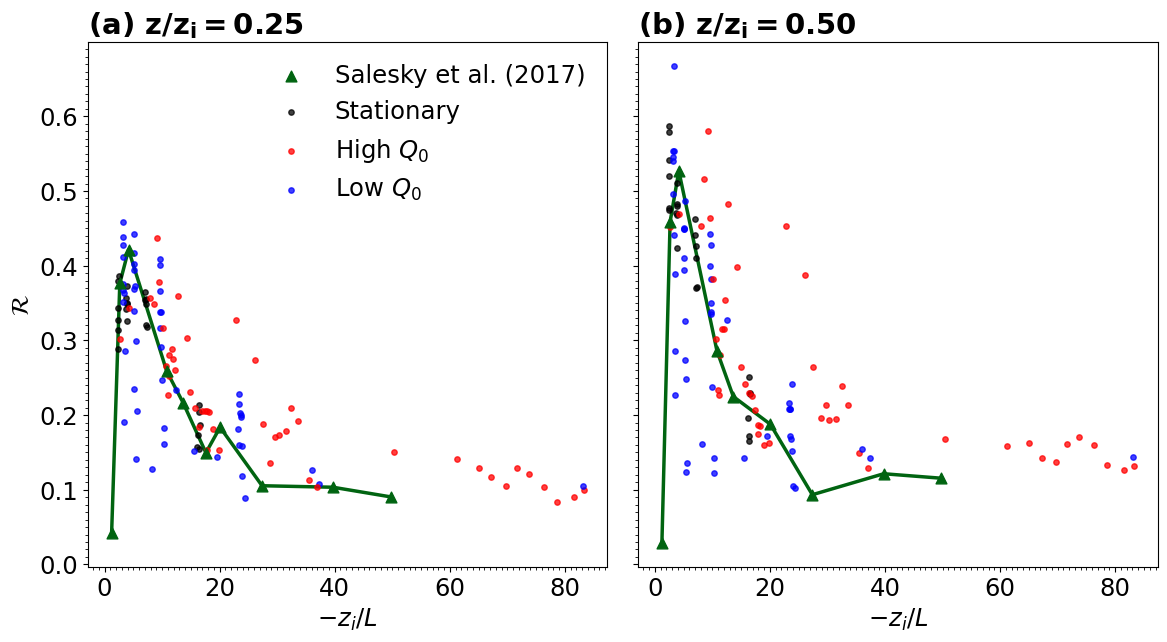

In [14]:
fig, ax = plt.subplots(figsize=(12,6.75), ncols=2, sharex=True, sharey=True)
    
dotsize = 15
alpha = 0.75
spacing = 18

# z/zi = 0.25
hidx = 1
for i in range(4):
    # U6-15
    ax[0].scatter(s_all[i].zi_L[:144:spacing], 
               roll[f"ug{uglist[i]}"][hidx,:144:spacing],
               c=colors2[0], s=dotsize, alpha=alpha)
    ax[0].scatter(s_all[i].zi_L[145:360:spacing], 
               roll[f"ug{uglist[i]}"][hidx,145:360:spacing],
               c=colors2[1], s=dotsize, alpha=alpha)
    ax[0].scatter(s_all[i].zi_L[361:577:spacing], 
               roll[f"ug{uglist[i]}"][hidx,361:577:spacing],
               c=colors2[2], s=dotsize, alpha=alpha)
# Salesky et al. (2017)
ax[0].scatter(salesky_160_zzi025_ziL, salesky_160_zzi025_R,
           label="Salesky et al. (2017)",
           c="#016411", s=60, alpha=1, marker="^")
ax[0].plot(salesky_160_zzi025_ziL, salesky_160_zzi025_R,
        c="#016411", lw=2.5, zorder=0)

# z/zi = 0.50
hidx = 2
for i in range(4):
    # U6-15
    ax[1].scatter(s_all[i].zi_L[:144:spacing], 
               roll[f"ug{uglist[i]}"][hidx,:144:spacing],
               c=colors2[0], s=dotsize, alpha=alpha)
    ax[1].scatter(s_all[i].zi_L[145:360:spacing], 
               roll[f"ug{uglist[i]}"][hidx,145:360:spacing],
               c=colors2[1], s=dotsize, alpha=alpha)
    ax[1].scatter(s_all[i].zi_L[361:577:spacing], 
               roll[f"ug{uglist[i]}"][hidx,361:577:spacing],
               c=colors2[2], s=dotsize, alpha=alpha)
# Salesky et al. (2017)
ax[1].scatter(salesky_160_zzi050_ziL, salesky_160_zzi050_R,
           label="Salesky et al. (2017)",
           c="#016411", s=60, alpha=1, marker="^")
ax[1].plot(salesky_160_zzi050_ziL, salesky_160_zzi050_R,
        c="#016411", lw=2.5, zorder=0)

# Plot a single scatter plot outside the loop with the label
ax[0].scatter([], [], c=colors2[0], s=dotsize, alpha=alpha, label="Stationary")
ax[0].scatter([], [], c=colors2[1], s=dotsize, alpha=alpha, label="High $Q_0$")
ax[0].scatter([], [], c=colors2[2], s=dotsize, alpha=alpha, label="Low $Q_0$")
ax[0].legend(frameon=False)

ax[0].set_xlabel("$-z_i / L$")
ax[1].set_xlabel("$-z_i / L$")
ax[0].set_ylabel("$\mathcal{R}$")

# ax[0].set_ylim(0,0.60)
ax[0].yaxis.set_minor_locator(MultipleLocator(0.01))
# ax[0].set_xlim(0,85)
ax[0].xaxis.set_minor_locator(MultipleLocator(1))

ax[0].set_title("(a) $\\bf{z/z_i = 0.25}$", loc="left")
ax[1].set_title("(b) $\\bf{z/z_i = 0.50}$", loc="left")

plt.tight_layout()

plt.savefig("/home/rfrost/manuscript_plots/2017_comparison.pdf", format="pdf", dpi=300, bbox_inches="tight")